# 局部极大值检测
对于检测局部极大值，即被强度较低的像素包围的像素，我们可以使用[scikit-image](https://scikit-image.org)和[clesperanto](https://github.com/clEsperanto/pyclesperanto_prototype)中的一些函数。

另请参阅
* [寻找局部极大值（scikit-image教程）](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_peak_local_max.html)

In [1]:
from skimage.feature import peak_local_max
import pyclesperanto_prototype as cle
from skimage.io import imread, imshow
from skimage.filters import gaussian 
import matplotlib.pyplot as plt

我们首先加载一张图像，并裁剪一个区域用于演示目的。我们使用了图像集[BBBC007v1](https://bbbc.broadinstitute.org/BBBC007)版本1（Jones等人，2005年ICCV计算机视觉生物医学图像应用研讨会论文集），该图像集可从Broad生物图像基准集合获得[Ljosa等人，Nature Methods，2012]。

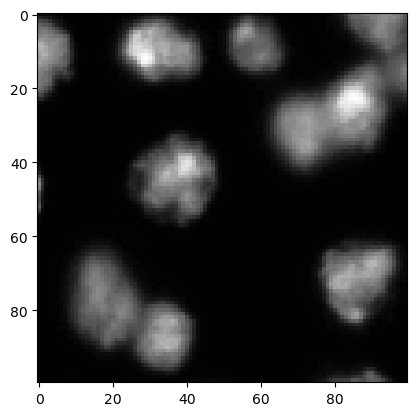

In [2]:
image = imread("../../data/BBBC007_batch/A9 p7d.tif")[-100:, 0:100]

cle.imshow(image)

## 预处理
在检测极大值之前，一个常见的预处理步骤是对图像进行模糊处理。这是有意义的，因为可以避免检测到仅由噪声引起的强度变化所产生的极大值。

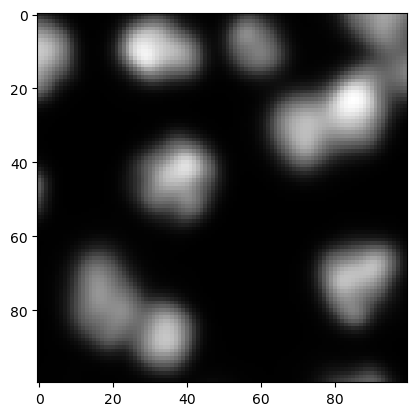

In [3]:
preprocessed = gaussian(image, sigma=2, preserve_range=True)

cle.imshow(preprocessed)

## peak_local_max
[`peak_local_max函数`](https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=peak_local_max#skimage.feature.peak_local_max)允许检测强度高于周围像素和其他极大值的极大值，这些极大值是根据定义的阈值确定的。

In [4]:
coordinates = peak_local_max(preprocessed, threshold_abs=5)
coordinates

array([[23, 85],
       [11, 29],
       [41, 40],
       [88, 34],
       [72, 83],
       [69, 89],
       [31, 72],
       [75, 16],
       [80, 22],
       [ 6, 56]], dtype=int64)

这些坐标可以使用matplotlib的plot函数进行可视化。

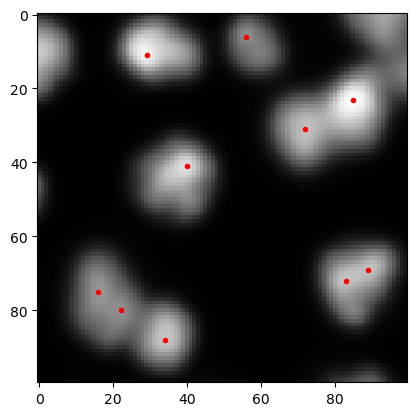

In [5]:
cle.imshow(preprocessed, continue_drawing=True)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

如果检测到的极大值太多，可以通过改变上面高斯模糊的`sigma`参数或改变传递给`peak_local_max`函数的阈值来修改结果。

## detect_maxima_box

`peak_local_max`函数在处理大型3D图像数据时往往需要很长时间。因此，这里介绍一个替代方案：clesperanto的`detect_maxima_box`是一个图像滤波器，如果周围像素的强度较低，它会将像素值设置为`1`。它通常在大型3D图像数据上也能快速执行。

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
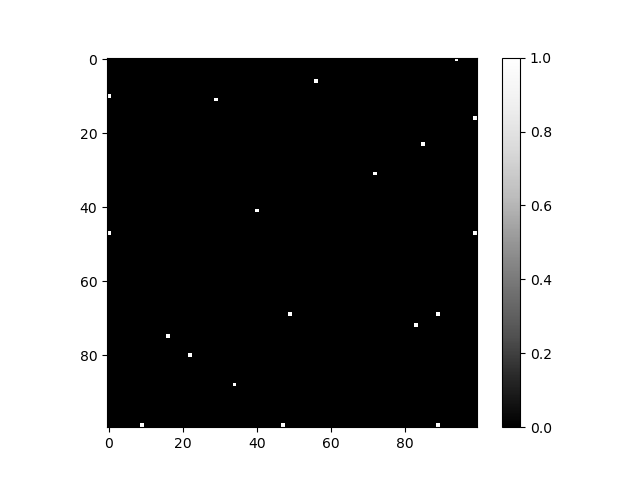
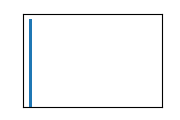

In [6]:
local_maxima_image = cle.detect_maxima_box(preprocessed)
local_maxima_image

显然，它会生成一个二值图像。这个二值图像可以通过用不同的数字标记各个斑点来转换为标签图像。从这个标签图像中，我们可以移除在图像边缘检测到的极大值，这在本例中可能是有用的。

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
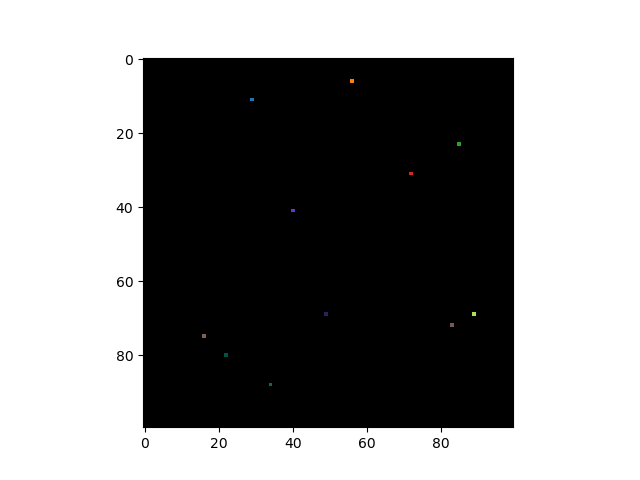

In [7]:
all_labeled_spots = cle.label_spots(local_maxima_image)

labeled_spots = cle.exclude_labels_on_edges(all_labeled_spots)
labeled_spots

为了在原始图像上可视化这些斑点，增加斑点的大小可能是有意义的 - 仅用于可视化目的。

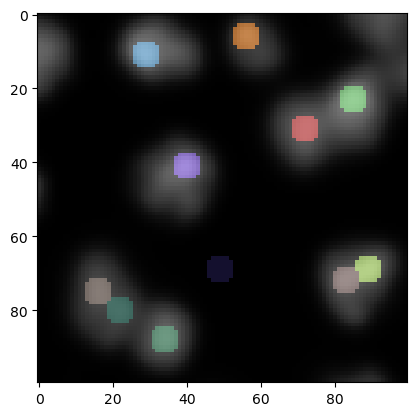

In [8]:
label_visualization = cle.dilate_labels(labeled_spots, radius=3)

cle.imshow(preprocessed, continue_drawing=True)
cle.imshow(label_visualization, labels=True, alpha=0.5)

在这个图像的下方中心，我们现在看到一个在背景中检测到的局部极大值。我们可以通过阈值处理来移除那些在低强度区域的极大值。

cl.OCLArray([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
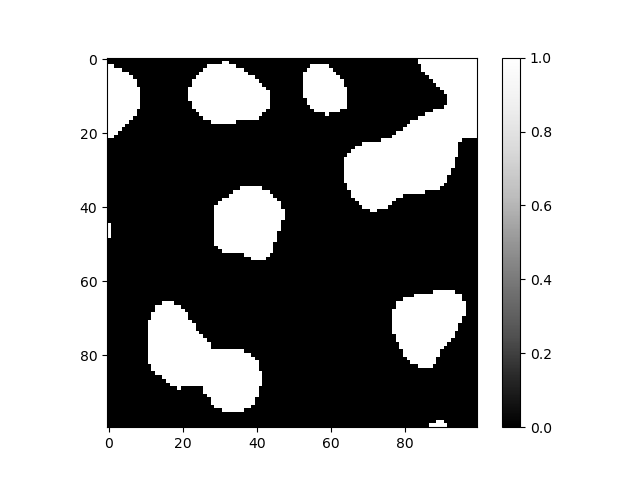
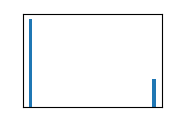

In [9]:
binary_image = cle.threshold_otsu(preprocessed)
binary_image

现在我们可以从斑点图像中排除那些二值图像中强度不在`[0..1]`范围内的标签。

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
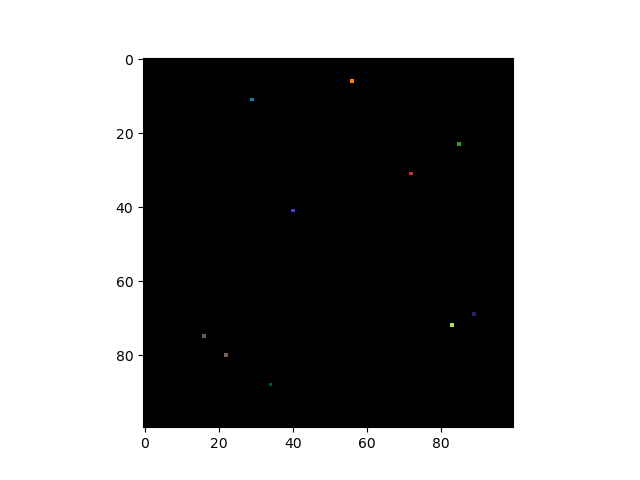

In [10]:
final_spots = cle.exclude_labels_with_map_values_out_of_range(
    binary_image,
    labeled_spots,
    minimum_value_range=1,
    maximum_value_range=1
)
final_spots

然后我们可以再次使用上面介绍的策略来可视化这些斑点，但这次是在原始图像上。

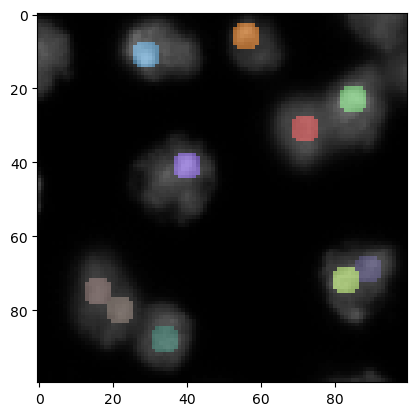

In [11]:
label_visualization2 = cle.dilate_labels(final_spots, radius=3)

cle.imshow(image, continue_drawing=True)
cle.imshow(label_visualization2, labels=True, alpha=0.5)